<a href="https://colab.research.google.com/github/EmilyRothrock/project_voting/blob/main/Voting_Paper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
#! git clone 'https://github.com/EmilyRothrock/project_voting'

#Summary

# Data

# Results - Random Forest Model

## Preparing, Creating, and Fitting the model

Cleaning for the data was done in 'data_cleaning.ipynb' which is located in the same repository as this report.

The following code block retrieves the cleaned data.

In [5]:
import pandas as pd
all_us_data = pd.read_csv('/content/project_voting/training_data.csv') # includes voting data on all US states except Virginia
va_data_2020 = pd.read_csv('/content/project_voting/testing_data.csv')

Then, the state and county columns are removed from the training data, so just the year, population, county_fips, and total_votes can be used by the model to predict the number of democratic and republican votes.

In [6]:
all_us_data = all_us_data.drop(columns=['state', 'county'])
y_train = all_us_data.loc[:, ['democrat_votes', 'republican_votes']]
X_train = all_us_data.drop(columns=['democrat_votes', 'republican_votes'])
X_train.head(5)

,year,population,county_fips,total_votes
0,2020,56145,1001,27770
1,2020,229287,1003,109679
2,2020,24589,1005,10518
3,2020,22136,1007,9595
4,2020,57879,1009,27588


This same process is repeated for the test data, which only includes Virginia.

In [7]:
virginia_counties = va_data_2020["county"]
va_data_2020 = va_data_2020.drop(columns=['state', 'county'])
y_test = va_data_2020.loc[:, ['democrat_votes', 'republican_votes']]
X_test = va_data_2020.drop(columns=['democrat_votes', 'republican_votes'])
X_test.head(5)

,year,population,county_fips,total_votes
0,2020,33191,51001,16962
1,2020,114534,51003,64657
2,2020,14835,51005,8203
3,2020,13455,51007,7894
4,2020,31589,51009,17005


The random forest model is created and fitted using a random forest regressor from sklearn.

In [8]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(random_state=30)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=30)

The R squared score is reported at 0.9809 for the training model and 0.8646 for the testing model.

In [9]:
train_score = model.score(X_train, y_train)
print(f'R2 score (train): {train_score:.4f}')

test_score = model.score(X_test, y_test)
print(f'R2 score (test): {test_score:.4f}')

R2 score (train): 0.9809
R2 score (test): 0.8646


The predicted values for the republican and democratic votes of each county are saved below.

In [10]:
model_predict = model.predict(X_test)

## Variable Importance

In the model's decision making, the number of total votes for a county was overwhelming used to predict the party outcome of the county. Population also had some importance in the decision making, but county_fips and year had practically none. There would be some concern if year and county_fips had any significant level of importance as year has the same value for every entry and county FIPS should be close to randomly assigned to identify counties.

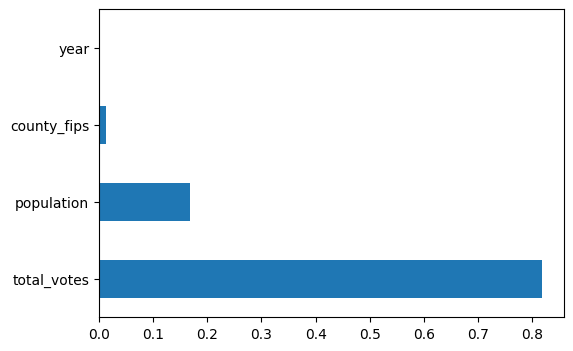

In [11]:
importance = pd.Series(model.feature_importances_,
                       index = X_train.columns.values)
importance.nlargest(5).plot(kind='barh',
                            figsize = (6,4));

## Predicted Values

The predicted values for the republican and democratic votes of each county are shown below. In total, the model predicted 1,949,364 democratic votes and 2,416,337 republican votes; the model predicts republicans will win Virginia.

In [12]:
predicted_values = pd.DataFrame({'democrat_votes': model_predict[:, 0], 'republican_votes': model_predict[:, 1]})
predicted_values = pd.concat([predicted_values, virginia_counties.rename("va_counties")], axis=1)
predicted_values = pd.concat([predicted_values, va_data_2020['county_fips'].rename("county_fips")], axis=1)
predicted_values

,democrat_votes,republican_votes,va_counties,county_fips
0,5045.24,11315.89,ACCOMACK,51001
1,24163.08,39109.45,ALBEMARLE,51003
2,2246.56,5883.22,ALLEGHANY,51005
3,2334.48,5509.55,AMELIA,51007
4,5258.19,11157.48,AMHERST,51009
...,...,...,...,...
128,17305.23,31141.52,SUFFOLK CITY,51800
129,108697.76,116321.81,VIRGINIA BEACH CITY,51810
130,2592.21,7877.32,WAYNESBORO CITY,51820
131,2217.71,4536.17,WILLIAMSBURG CITY,51830


In [13]:
#predicted democratic votes
sum(model_predict[:, 0])

1949364.5799999996

In [14]:
#predicted republican votes
sum(model_predict[:, 1])

2416337.059999999

# Conclusion